<a href="https://colab.research.google.com/github/BenYavor/Autoencoder_communication_system_WGAN_Channel-estimation/blob/master/Communication_Autoencoder_with_WGAN_PL_alternating_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
tf.__version__
from tensorflow import keras
import time
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import sys
assert sys.version_info >= (3, 5)
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from scipy import special
from tensorflow.keras import layers
np.random.seed(42)
tf.random.set_seed(42)

#### Vergleich
Als erstes für feste $k$ und $n$, was sich ändert ist die Samplesize, Anzahl der Samples und SNR

###Systemparameter
ACHTUNG: CHANNELANZAHL WURDE UNTERSCHIEDLICH VERWENDET \\
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses\\
$N$ - Länge des Rauschvektors

In [2]:
k = 4      # Number of information bits per message, i.e., M=2**k
M = 2**k
n = 2    # Number of real channel uses per message
#k = int(np.log2(M))
#n = 2
print(M)

SNR = 7
time_to_train_w_gan = 0

16


## Training Parameter

In [0]:
gen_learning_rate=0.0001 
disc_learning_rate = 0.0001                  # 0.0001  

### Different Layers

In [0]:
randN_initial = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
ones_initial = keras.initializers.GlorotNormal()

EncIn = tf.keras.layers.Input(shape=(M,))#, dtype= tf.int32)
e1 = tf.keras.layers.Dense(2*n, activation=None)
e2 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
EncOut = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(2*tf.reduce_mean(tf.square(x))))
GenIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))
# = tf.keras.layers.Lambda(generator)
DecIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
d1 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,n]))
d2 = tf.keras.layers.Dense(M, activation='relu')
DecOut = tf.keras.layers.Dense(M, activation='softmax')


#noise_std = EbNo_to_noise(TRAINING_SNR)
# custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,n]))
channel_layer = keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))

### Help functions

In [5]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB]/snr to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*(2*k/n)*ebno) 
    return noise_std


def real_channel(x,noise_std):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

def rayleigh_channel(x,noise_std):
    return x + tf.sqrt(tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random_uniform(tf.shape(x), minval=-2, maxval=2)

def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def random_sample(batch_size=32):
    msg = np.random.randint(M, size=batch_size)
    return msg




def B_Ber_m(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(input_msg, tf.argmax(msg, 1))      
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

noise_std = EbNo2Sigma(SNR)

print(EbNo2Sigma(SNR))
print(EbNo_to_noise(SNR))

0.15792649852735607
0.15792649852735607


In [0]:
def test_encoding(M=16, n=1):
    inp = np.arange(0,M)
    coding = encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()
  


# Models

#### Generator Model

In [0]:
def get_generator(n):
  input1 = tf.keras.layers.Input(shape=(n,))
  x1 = tf.keras.layers.Dense(n,kernel_initializer=randN_initial)(input1)
  input2 =tf.random.normal(shape=tf.shape(input1))
  #input2 =tf.random.normal([tf.shape(input1)[0],n]) r 
  x2 = tf.keras.layers.Dense(n,kernel_initializer=randN_initial)(input2)
  subtracted = tf.keras.layers.Concatenate(1)([x1, x2])
  h1 = tf.keras.layers.Dense(64,use_bias=True,  activation='relu')(subtracted)
  h2 = tf.keras.layers.Dense(32,use_bias=True,kernel_initializer=ones_initial, activation='relu')(h1)
  out = tf.keras.layers.Dense(n, use_bias= True, kernel_initializer=ones_initial,activation='linear')(h2)
  generator = tf.keras.models.Model(inputs=[input1], outputs=out)
  return generator


#### Discriminator Model 

In [0]:
def get_discriminator(n):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(32,use_bias=True, activation='relu',input_shape=((2*n,))))
  model.add(tf.keras.layers.Dense(32,use_bias=True,  activation='relu'))
  model.add(tf.keras.layers.Dense(1,use_bias=False, activation='linear'))
  return model
  

In [0]:
generator = get_generator(n)
discriminator=get_discriminator(n)

## Encoder Model

In [0]:
def get_gan_encoder(M):
  model = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M*2, activation="elu"),
            keras.layers.Dense(M*2, activation="elu"),
            keras.layers.Dense(n,kernel_initializer=ones_initial, activation=None),
            e2,
            EncOut,
            GenIn])
  return model

## Decoder Model

In [0]:
def get_gan_decoder(M):
   model= keras.models.Sequential([
                #DecIn,
                #d1,
                keras.layers.Input(shape=(n,)),
                keras.layers.Dense(M*2,  activation="elu"),
                keras.layers.Dense(M*2, activation="elu"),
                keras.layers.Dense(M, kernel_initializer=ones_initial, activation="softmax")
                ])
   return model

### GAN Training functions

In [0]:
# optimizers
w_gen_optimizer = tf.keras.optimizers.RMSprop(0.0001)# RMSprop(0.0001)#(0.0001, beta_1=0.5,beta_2 =0.1) # works as well
w_disc_optimizer = tf.keras.optimizers.RMSprop(0.0001)#(0.0001, beta_1=0.5,beta_2 =0.1)  #(0.001)# train the model




encoder = get_gan_encoder(M)
decoder = get_gan_decoder(M)


In [0]:
@tf.function
def train(batch_size):
  gen_gradients, disc_gradients = compute_gradients(batch_size)
  apply_gradients(gen_gradients, disc_gradients)

In [0]:
@tf.function
def compute_gradients(batch_size):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    disc_loss, gen_loss = compute_loss(batch_size)
    #tf.print("gen_loss:", gen_loss)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  return gen_gradients, disc_gradients

In [0]:
def compute_loss(batch_size):
  """ passes through the network and computes loss
  """
        ### pass through network
        # generating noise from a uniform distribution
  ####Mein noise ist anders als hier
  gradient_penalty_weight = 0.1   #0.5
  #print(x_samp)
  # run noise through generator
  m =random_sample(batch_size)
  r = encoder(m)
  real_data = tf.concat(values=[real_channel(r,noise_std), r], axis=1)
  fake_data = tf.concat(values=[generator(r),r], axis=1)
  # discriminate x and x_gen
  logits_x = discriminator(real_data)
  logits_x_gen = discriminator(fake_data)

  # gradient penalty
  d_regularizer = gradient_penalty(real_data, fake_data)
        ### losses
  disc_loss = (tf.reduce_mean(logits_x) - tf.reduce_mean(logits_x_gen)- d_regularizer * gradient_penalty_weight)

        # losses of fake with label "1"
  gen_loss = -tf.reduce_mean(logits_x_gen)
  return disc_loss, gen_loss



def apply_gradients(gen_gradients, disc_gradients):

  w_gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  w_disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

def gradient_penalty(x, x_gen):
  epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
  #epsilon = tf.random.uniform(shape = x.shape, minval= 0.0, maxval= 1.0)
  x_hat = epsilon * x + (1 - epsilon) * x_gen
  with tf.GradientTape() as t:
      t.watch(x_hat)
      d_hat = discriminator(x_hat)
  gradients = t.gradient(d_hat, x_hat)
  ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
  d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
  #tf.print("gradient_penalty")
  #tf.print(d_regularizer)
  return d_regularizer



In [0]:
def compute_loss(batch_size):
  """ passes through the network and computes loss
  """
        ### pass through network
        # generating noise from a uniform distribution
  ####Mein noise ist anders als hier
  gradient_penalty_weight = 0.1   #0.5
  #print(x_samp)
  # run noise through generator
  m =random_sample(batch_size)
  r = encoder(m)
  real_data = tf.concat(values=[real_channel(r,noise_std), r], axis=1)
  fake_data = tf.concat(values=[generator(r),r], axis=1)
  # discriminate x and x_gen
  logits_x = discriminator(real_data)
  logits_x_gen = discriminator(fake_data)

  # gradient penalty
  d_regularizer = gradient_penalty(real_data, fake_data)
        ### losses
  disc_loss = (tf.reduce_mean(logits_x) - tf.reduce_mean(logits_x_gen)+ d_regularizer * gradient_penalty_weight)

        # losses of fake with label "1"
  gen_loss = tf.reduce_mean(logits_x_gen)
  return disc_loss, gen_loss

In [0]:
def generate_evaluation_data(batch_size=100):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )
  fake_eval_data = generator([x])
  real_eval_data = real_channel(x,noise_std) #tf.concat(values=[real_channel(x),x], axis=1)
  inputs = x
  return  real_eval_data, fake_eval_data, inputs 



def get_evaluation_data(evaluation_per_epochs=100):
  real_eval_data = []
  fake_eval_data  = []
  inputs = []
  for i in range(evaluation_per_epochs):
    data = generate_evaluation_data()
    real_eval_data.append(data[0])
    fake_eval_data.append(data[1])
    inputs.append(data[2])
  return real_eval_data, fake_eval_data, inputs


def test_eval(real_eval_data,fake_eval_data,inputs):
  hist_range = 1
  
  
  fake_output_hist = np.mean(fake_eval_data,axis=0)  # Changed from 0 to 1
  real_output_hist = np.mean(real_eval_data,axis=0)
  inputs_hist = np.mean(inputs,axis=0)
    
  fake_output_hist1 = np.reshape( fake_output_hist,[-1,])
  real_output_hist1 = np.reshape( real_output_hist,[-1,])
    
  plt.hist(fake_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')
  plt.hist(real_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')    
  plt.title("noise distribution")
  plt.legend(["generator", "target"])
  plt.show()


In [0]:
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

In [0]:
def gen_train(n_epochs,batch_size):
  generator.trainable =True
  start = time.time()
  for epoch in range(n_epochs):
    x= tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)
    x_samp =x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
    train(batch_size)
    # test on holdout
    loss = []
    if epoch%500 == 0:
      real_c = tf.concat(values=[real_channel(x,noise_std), x], axis=1)
      fake_c = generator(x)
      real_eval_data, fake_eval_data, inputs = get_evaluation_data()
      test_eval(real_eval_data, fake_eval_data, inputs)
      tf.print(fake_c[0])
      #tf.print(disc_loss, gen_loss)
    real_data = tf.concat(values=[real_channel(x,noise_std), x], axis=1)  
    loss.append(compute_loss(batch_size))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    if epoch%100 == 0:
      print(
         "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
              epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
         )  )
  tf.saved_model.save(generator,'/tmp/saved_model/')
  #plt.plot(losses.disc_loss.values)
  generator.trainable =False



In [0]:
def creating_and_train_gan(epochs,n_steps, batch_size, SNR_level , n ):  #optional Leraning Rates
  generator.trainable = True
  train_gan(epochs, n_steps, batch_size, SNR_level)
  #4 after GAN training
 # generator.trainable = False
  #tf.print(generator.trainable)

In [0]:
def gan_Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = encoder(data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        dcoded_msg = decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)

def Test_AE_rayleigh(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = encoder(data)
        rcvd_word = rayleigh_channel(code_word, noise_std)
        dcoded_msg = decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)


# Resiver Training

In [0]:
decoder = get_gan_decoder(M)
encoder = get_gan_encoder(M)


channel_layer = keras.layers.Lambda(lambda x: real_channel(x,noise_std))

# Decoder Training

In [0]:
data = random_sample(100)

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_object_a = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
decoder_optimizer = tf.keras.optimizers.Adam()

def decoder_loss(decoder, x, y):
  x_ = encoder(x)
  y1= channel_layer(x_)
  #y1 = generator(x_)
  y_ = decoder(y1)
  return loss_object(y_true=y, y_pred=y_)

#def decoder_loss2(decoder, x, y):
#  x_ = encoder(x)
#  y1 = generator(x_)
#  y_ = decoder(y1)
#  return loss_object(y_true=y, y_pred=y_)

@tf.function
def decoder_grad(model, inputs, targets):
  with tf.GradientTape() as decoder_tape:
    loss_value = decoder_loss(model, inputs, targets)
  return loss_value, decoder_tape.gradient(loss_value, model.trainable_variables)

#@tf.function
#def decoder_grad2(model, inputs, targets):
#  with tf.GradientTape() as decoder_tape:
#    loss_value = decoder_loss2(model, inputs, targets)
#  return loss_value, decoder_tape.gradient(loss_value, model.trainable_variables)



In [0]:

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

def decoder_training(num_epochs,batch_size):
  for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    data = random_sample(batch_size)
    loss_value = decoder_step_training()
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(data, decoder(channel_layer(encoder(data))))   
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 500 == 0:
      print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                      epoch_accuracy.result()))
@tf.function                                                                
def decoder_step_training():
  loss_value, decoder_grads = decoder_grad(decoder, data, data)
  decoder_optimizer.apply_gradients(zip(decoder_grads, decoder.trainable_variables))
  return loss_value  

#@tf.function                                                                
#def decoder_step_training2():
#  loss_value, decoder_grads = decoder_grad2(decoder, data, data)
#  decoder_optimizer.apply_gradients(zip(decoder_grads, decoder.trainable_variables))
#  return loss_value  


# Transmitter Training

In [0]:
encoder_optimizer = tf.keras.optimizers.Adam()

def encoder_loss(encoder, x, y):
  x_ = encoder(x)
  y1= generator(x_)
  y_ = decoder(y1)
  return loss_object_a(y_true=y, y_pred=y_)

@tf.function
def encoder_grad(model, inputs, targets):
  with tf.GradientTape() as encoder_tape:
    loss_value = encoder_loss(model, inputs, targets)
  return loss_value, encoder_tape.gradient(loss_value, model.trainable_variables)



In [27]:
loss_value, encoder_grads = encoder_grad(encoder,data, data)

print("Step: {}, Initial Loss: {}".format(encoder_optimizer.iterations.numpy(),
                                          loss_value.numpy()))

encoder_optimizer.apply_gradients(zip(encoder_grads, encoder.trainable_variables))

print("Step: {},         Loss: {}".format(encoder_optimizer.iterations.numpy(),
                                          encoder_loss(encoder, data, data).numpy()))


Step: 0, Initial Loss: 2.7726035118103027
Step: 1,         Loss: 2.772597312927246


In [0]:

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

def encoder_training(num_epochs, batch_size = 400):
  for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    data = random_sample(batch_size)

    loss_value = encoder_step_training()
      #loss_value, encoder_grads = encoder_grad(encoder, data, data)
      #encoder_optimizer.apply_gradients(zip(encoder_grads, encoder.trainable_variables))
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(data, decoder(generator(encoder(data))))  
   # train_loss_results.append(epoch_loss_avg.result())
   # train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 500 == 0:
      print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
@tf.function
def encoder_step_training():
  loss_value, encoder_grads = encoder_grad(encoder, data, data)
  encoder_optimizer.apply_gradients(zip(encoder_grads, encoder.trainable_variables))
  return loss_value



In [0]:
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
loss =[]

# GAN Training

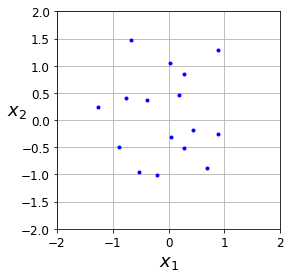

Epoch 000: Loss: 2.772, Accuracy: 4.000%
Epoch 500: Loss: 2.184, Accuracy: 71.000%


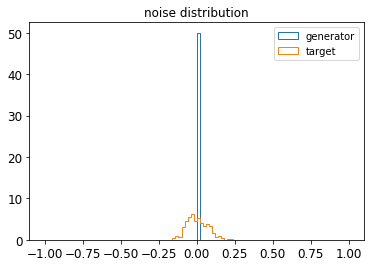

[0.00990810432 0.0267948918]
Epoch: 0 | disc_loss: 0.13239866495132446 | gen_loss: 0.2011384218931198
Epoch: 100 | disc_loss: -0.05166175216436386 | gen_loss: 0.13279134035110474
Epoch: 200 | disc_loss: -0.16987478733062744 | gen_loss: 0.07972300797700882
Epoch: 300 | disc_loss: -0.1889711320400238 | gen_loss: 0.09166750311851501
Epoch: 400 | disc_loss: -0.1991514265537262 | gen_loss: 0.13425199687480927


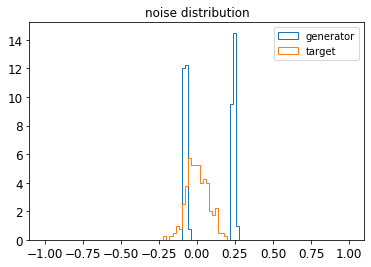

[-0.167226851 0.148832858]
Epoch: 500 | disc_loss: -0.1818704903125763 | gen_loss: 0.1367156058549881
Epoch: 600 | disc_loss: -0.17431241273880005 | gen_loss: 0.1306668221950531
Epoch: 700 | disc_loss: -0.1683279573917389 | gen_loss: 0.13143904507160187
Epoch: 800 | disc_loss: -0.16591520607471466 | gen_loss: 0.12285110354423523
Epoch: 900 | disc_loss: -0.142843097448349 | gen_loss: 0.12766723334789276


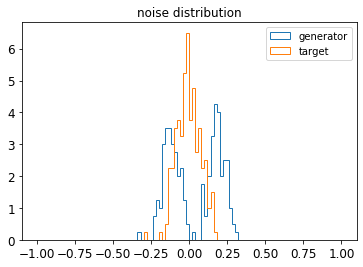

[-0.80683881 -0.396689087]
Epoch: 1000 | disc_loss: -0.13153958320617676 | gen_loss: 0.1329178661108017
Epoch: 1100 | disc_loss: -0.13108620047569275 | gen_loss: 0.1185571700334549
Epoch: 1200 | disc_loss: -0.09553138166666031 | gen_loss: 0.10701093822717667
Epoch: 1300 | disc_loss: -0.08035221695899963 | gen_loss: 0.07343532890081406
Epoch: 1400 | disc_loss: -0.09577490389347076 | gen_loss: 0.07401382178068161


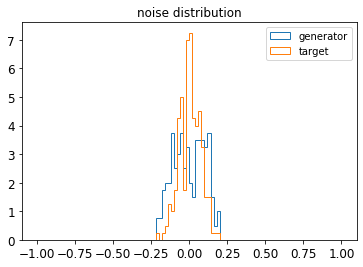

[-0.198752314 0.0165313371]
Epoch: 1500 | disc_loss: -0.0643484815955162 | gen_loss: 0.04991856962442398
Epoch: 1600 | disc_loss: -0.033485062420368195 | gen_loss: 0.04733186587691307
Epoch: 1700 | disc_loss: -0.010908727534115314 | gen_loss: 0.04926665872335434
Epoch: 1800 | disc_loss: 0.0007749837823212147 | gen_loss: 0.07151156663894653
Epoch: 1900 | disc_loss: 0.005860223434865475 | gen_loss: 0.09957441687583923


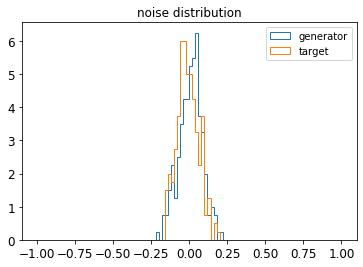

[1.5705682 0.911077559]
Epoch: 2000 | disc_loss: -0.0037130292039364576 | gen_loss: 0.10092560946941376
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/saved_model/assets
Epoch 000: Loss: 2.178, Accuracy: 65.000%
Epoch 500: Loss: 2.141, Accuracy: 66.000%
Epoch 1000: Loss: 2.155, Accuracy: 69.000%
Epoch 1500: Loss: 2.132, Accuracy: 56.000%
Epoch 2000: Loss: 2.145, Accuracy: 61.000%
Epoch 000: Loss: 2.287, Accuracy: 59.000%
Epoch 500: Loss: 2.070, Accuracy: 69.000%
Epoch 1000: Loss: 2.098, Accuracy: 73.000%
Epoch 1500: Loss: 2.109, Accuracy: 80.000%


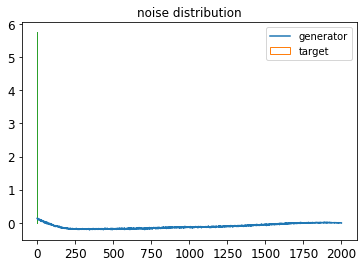

[-0.611416757 -0.508513331]
Epoch: 0 | disc_loss: -0.0048472685739398 | gen_loss: 0.12120173126459122
Epoch: 100 | disc_loss: 0.0018924889154732227 | gen_loss: 0.09467267990112305
Epoch: 200 | disc_loss: 0.0124894380569458 | gen_loss: 0.10439456254243851
Epoch: 300 | disc_loss: 0.009374314919114113 | gen_loss: 0.14479666948318481
Epoch: 400 | disc_loss: 0.004368382506072521 | gen_loss: 0.14584557712078094


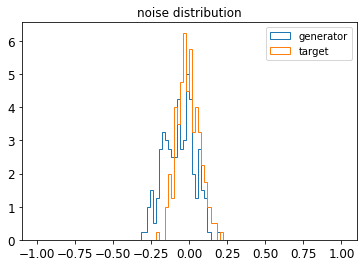

[-1.23888469 0.931083322]
Epoch: 500 | disc_loss: 0.0005838256329298019 | gen_loss: 0.10957646369934082
Epoch: 600 | disc_loss: 0.004156539216637611 | gen_loss: 0.069769948720932
Epoch: 700 | disc_loss: 0.005100400652736425 | gen_loss: 0.11343438923358917
Epoch: 800 | disc_loss: -0.0023764120414853096 | gen_loss: 0.15713223814964294
Epoch: 900 | disc_loss: 0.0016624259296804667 | gen_loss: 0.13097116351127625


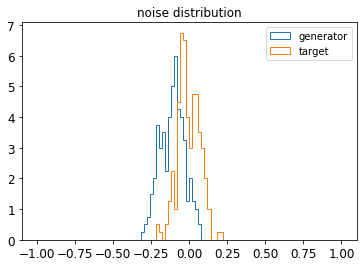

[-0.215345427 0.600425124]
Epoch: 1000 | disc_loss: 0.0075803836807608604 | gen_loss: 0.11539235711097717
Epoch: 1100 | disc_loss: -0.0026279096491634846 | gen_loss: 0.09470795840024948
Epoch: 1200 | disc_loss: 0.006795864552259445 | gen_loss: 0.08597561717033386
Epoch: 1300 | disc_loss: 0.004942447878420353 | gen_loss: 0.08628575503826141
Epoch: 1400 | disc_loss: 0.0029735879506915808 | gen_loss: 0.10853402316570282


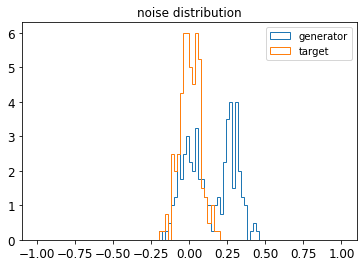

[-1.35003424 -0.272158861]
Epoch: 1500 | disc_loss: 0.005666068755090237 | gen_loss: 0.11287564039230347
Epoch: 1600 | disc_loss: -0.003481311956420541 | gen_loss: 0.13276390731334686
Epoch: 1700 | disc_loss: 0.0069988807663321495 | gen_loss: 0.11061146855354309
Epoch: 1800 | disc_loss: 0.004995392635464668 | gen_loss: 0.10067387670278549
Epoch: 1900 | disc_loss: -0.0031726714223623276 | gen_loss: 0.11128248274326324


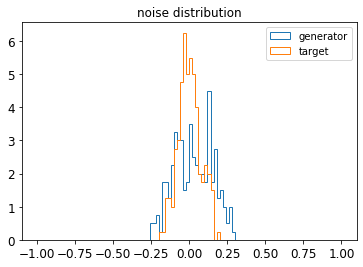

[-1.51459479 0.597754955]
Epoch: 2000 | disc_loss: 0.003926906734704971 | gen_loss: 0.08731354773044586
INFO:tensorflow:Assets written to: /tmp/saved_model/assets


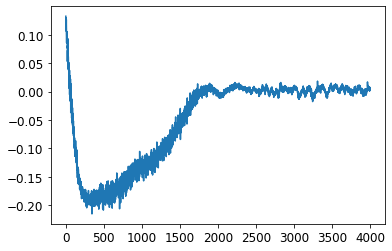

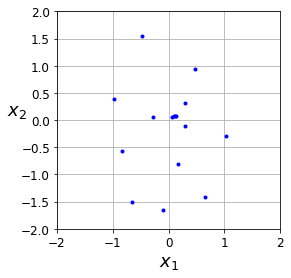

Epoch 000: Loss: 2.154, Accuracy: 65.000%
Epoch 500: Loss: 2.085, Accuracy: 59.000%


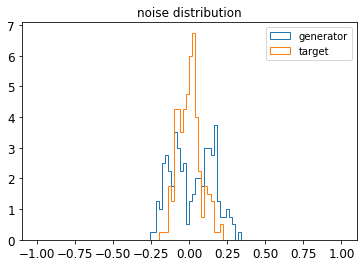

[-0.149209186 0.618332684]
Epoch: 0 | disc_loss: 0.0025584520772099495 | gen_loss: 0.086737722158432
Epoch: 100 | disc_loss: 0.0023159822449088097 | gen_loss: 0.1002032682299614
Epoch: 200 | disc_loss: 0.006151395384222269 | gen_loss: 0.11216311156749725
Epoch: 300 | disc_loss: 0.009287884458899498 | gen_loss: 0.10133398324251175
Epoch: 400 | disc_loss: 9.496230632066727e-06 | gen_loss: 0.10895581543445587


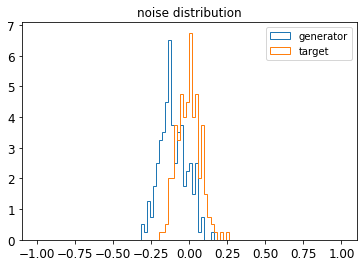

[0.0770000666 -0.329488516]
Epoch: 500 | disc_loss: 0.005413124803453684 | gen_loss: 0.10378683358430862
Epoch: 600 | disc_loss: 0.005082976073026657 | gen_loss: 0.09798270463943481
Epoch: 700 | disc_loss: -0.006098911166191101 | gen_loss: 0.10120593756437302
Epoch: 800 | disc_loss: 0.0022860695607960224 | gen_loss: 0.07751763612031937
Epoch: 900 | disc_loss: 0.0011348938569426537 | gen_loss: 0.10415532439947128


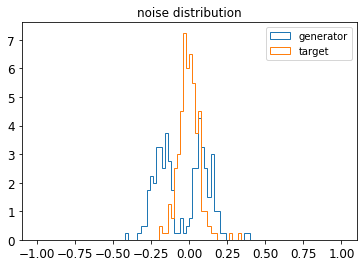

[0.485722125 -1.73964989]
Epoch: 1000 | disc_loss: -0.0027405957225710154 | gen_loss: 0.11030377447605133
Epoch: 1100 | disc_loss: 0.004474043380469084 | gen_loss: 0.10108885169029236
Epoch: 1200 | disc_loss: 0.0014605815522372723 | gen_loss: 0.10496595501899719
Epoch: 1300 | disc_loss: 0.0033396671060472727 | gen_loss: 0.10712296515703201
Epoch: 1400 | disc_loss: 0.003517479868605733 | gen_loss: 0.10090787708759308


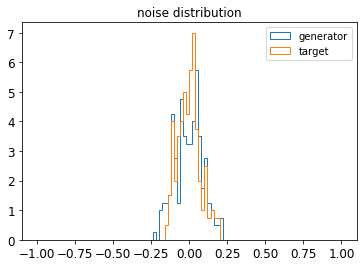

[0.0604666099 0.431360602]
Epoch: 1500 | disc_loss: -0.001394154503941536 | gen_loss: 0.10279590636491776
Epoch: 1600 | disc_loss: -0.0007443053764291108 | gen_loss: 0.10535246133804321
Epoch: 1700 | disc_loss: -6.924441549926996e-05 | gen_loss: 0.11260990053415298
Epoch: 1800 | disc_loss: 0.005452937446534634 | gen_loss: 0.12284518033266068
Epoch: 1900 | disc_loss: -0.00921281985938549 | gen_loss: 0.14937536418437958


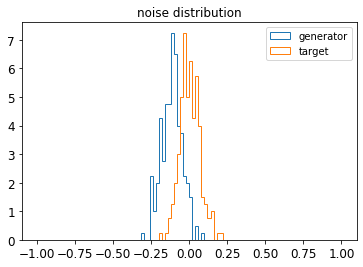

[-0.801184237 -0.665469944]
Epoch: 2000 | disc_loss: 0.0041219694539904594 | gen_loss: 0.12263493239879608
INFO:tensorflow:Assets written to: /tmp/saved_model/assets
Epoch 000: Loss: 2.107, Accuracy: 77.000%
Epoch 500: Loss: 2.117, Accuracy: 70.000%
Epoch 1000: Loss: 2.082, Accuracy: 67.000%
Epoch 1500: Loss: 2.097, Accuracy: 72.000%
Epoch 2000: Loss: 2.084, Accuracy: 76.000%
Epoch 000: Loss: 2.061, Accuracy: 72.000%
Epoch 500: Loss: 2.042, Accuracy: 84.000%
Epoch 1000: Loss: 2.042, Accuracy: 72.000%
Epoch 1500: Loss: 2.041, Accuracy: 81.000%


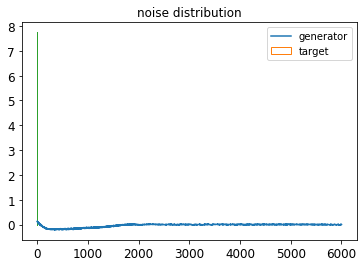

[1.04576433 -0.396813869]
Epoch: 0 | disc_loss: 0.011450412683188915 | gen_loss: 0.12291425466537476
Epoch: 100 | disc_loss: -0.004707139451056719 | gen_loss: 0.12070348858833313
Epoch: 200 | disc_loss: -0.008153470233082771 | gen_loss: 0.13372883200645447
Epoch: 300 | disc_loss: 0.004374827723950148 | gen_loss: 0.1291200965642929
Epoch: 400 | disc_loss: -0.006782027427107096 | gen_loss: 0.15051980316638947


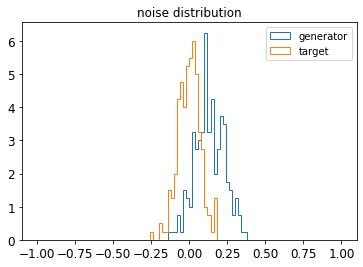

[-0.632985294 1.07314289]
Epoch: 500 | disc_loss: 0.009204770438373089 | gen_loss: 0.12795595824718475
Epoch: 600 | disc_loss: 0.004020765423774719 | gen_loss: 0.1312459409236908
Epoch: 700 | disc_loss: 0.0016766181215643883 | gen_loss: 0.15375880897045135
Epoch: 800 | disc_loss: -0.00028693079366348684 | gen_loss: 0.11575572192668915
Epoch: 900 | disc_loss: 0.004002240486443043 | gen_loss: 0.1312922090291977


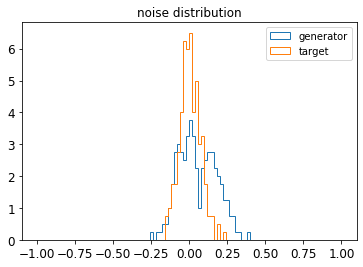

[-1.52994299 -1.70587313]
Epoch: 1000 | disc_loss: 0.002643261570483446 | gen_loss: 0.14538998901844025
Epoch: 1100 | disc_loss: 0.004656477831304073 | gen_loss: 0.14931711554527283
Epoch: 1200 | disc_loss: 0.0036449464969336987 | gen_loss: 0.12850822508335114
Epoch: 1300 | disc_loss: 0.009616807103157043 | gen_loss: 0.11255927383899689
Epoch: 1400 | disc_loss: 0.007571898866444826 | gen_loss: 0.1236097514629364


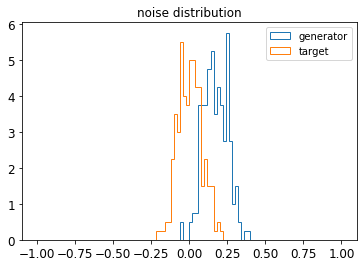

[-0.258088261 0.456373423]
Epoch: 1500 | disc_loss: -0.00802947860211134 | gen_loss: 0.1465662568807602
Epoch: 1600 | disc_loss: -0.011233697645366192 | gen_loss: 0.1170298159122467
Epoch: 1700 | disc_loss: -0.008685995824635029 | gen_loss: 0.09266118705272675
Epoch: 1800 | disc_loss: 0.009414366446435452 | gen_loss: 0.11526010185480118
Epoch: 1900 | disc_loss: 0.001636310014873743 | gen_loss: 0.15693436563014984


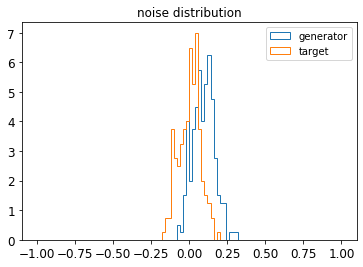

[0.987741649 -0.531828761]
Epoch: 2000 | disc_loss: -0.006732289679348469 | gen_loss: 0.1836983561515808
INFO:tensorflow:Assets written to: /tmp/saved_model/assets


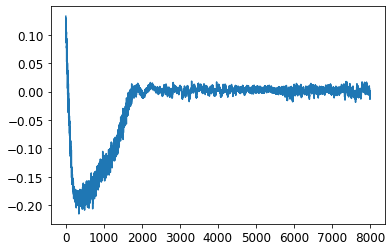

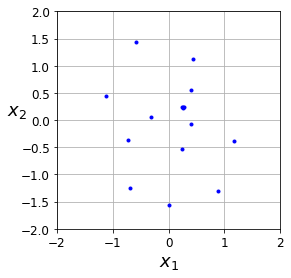

Epoch 000: Loss: 2.175, Accuracy: 70.000%
Epoch 500: Loss: 2.079, Accuracy: 64.000%


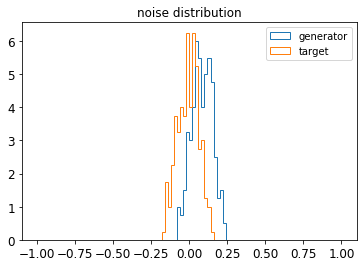

[0.331022143 -0.323691636]
Epoch: 0 | disc_loss: -0.0039607929065823555 | gen_loss: 0.1810600310564041
Epoch: 100 | disc_loss: -0.01658685877919197 | gen_loss: 0.16362027823925018
Epoch: 200 | disc_loss: 0.005339258350431919 | gen_loss: 0.10090268403291702
Epoch: 300 | disc_loss: 0.004777244292199612 | gen_loss: 0.09115827828645706
Epoch: 400 | disc_loss: -0.016876978799700737 | gen_loss: 0.09895951300859451


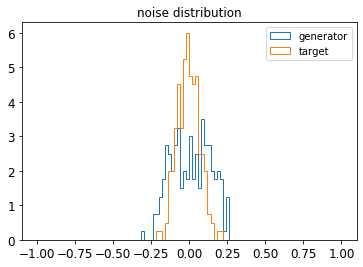

[-1.54260504 0.0361992046]
Epoch: 500 | disc_loss: -0.0007257690303958952 | gen_loss: 0.09009244292974472
Epoch: 600 | disc_loss: 0.0035048536956310272 | gen_loss: 0.11063053458929062
Epoch: 700 | disc_loss: 0.0016598306829109788 | gen_loss: 0.12798938155174255
Epoch: 800 | disc_loss: -0.002129416912794113 | gen_loss: 0.12809084355831146
Epoch: 900 | disc_loss: 0.007928879000246525 | gen_loss: 0.0893770307302475


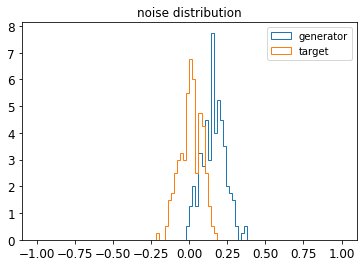

[-0.0562594533 -1.13833451]
Epoch: 1000 | disc_loss: 0.0002693127025850117 | gen_loss: 0.06978938728570938
Epoch: 1100 | disc_loss: -0.003508733119815588 | gen_loss: 0.044035837054252625
Epoch: 1200 | disc_loss: -0.00218927557580173 | gen_loss: 0.044891152530908585
Epoch: 1300 | disc_loss: 0.0028724772855639458 | gen_loss: 0.07008260488510132
Epoch: 1400 | disc_loss: -0.003872133558616042 | gen_loss: 0.09175137430429459


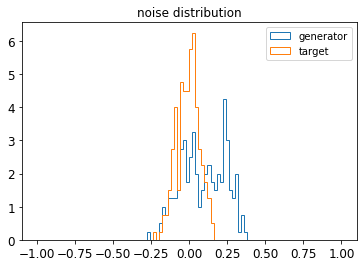

[-0.0328585207 1.11320138]
Epoch: 1500 | disc_loss: -0.0016910287085920572 | gen_loss: 0.10383797436952591
Epoch: 1600 | disc_loss: 0.0037451889365911484 | gen_loss: 0.08535350114107132
Epoch: 1700 | disc_loss: 0.0006773376953788102 | gen_loss: 0.06515733152627945
Epoch: 1800 | disc_loss: 0.0010544712422415614 | gen_loss: 0.051795512437820435
Epoch: 1900 | disc_loss: 0.00537843955680728 | gen_loss: 0.031180061399936676


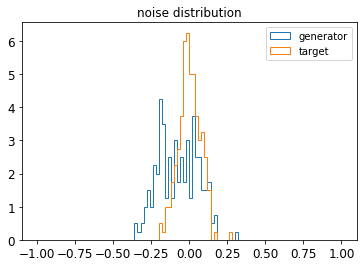

[0.599481 1.19031465]
Epoch: 2000 | disc_loss: 0.0005642770556733012 | gen_loss: 0.056529246270656586
INFO:tensorflow:Assets written to: /tmp/saved_model/assets
Epoch 000: Loss: 2.077, Accuracy: 75.000%
Epoch 500: Loss: 2.086, Accuracy: 65.000%
Epoch 1000: Loss: 2.058, Accuracy: 70.000%
Epoch 1500: Loss: 2.065, Accuracy: 74.000%
Epoch 2000: Loss: 2.058, Accuracy: 75.000%
Epoch 000: Loss: 2.054, Accuracy: 72.000%
Epoch 500: Loss: 2.042, Accuracy: 80.000%
Epoch 1000: Loss: 2.042, Accuracy: 60.000%
Epoch 1500: Loss: 2.043, Accuracy: 70.000%


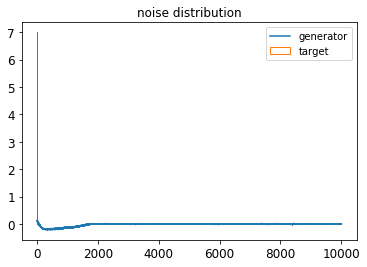

[-0.43911317 0.628926516]
Epoch: 0 | disc_loss: 0.00046433694660663605 | gen_loss: 0.05580693855881691
Epoch: 100 | disc_loss: -0.0006619051564484835 | gen_loss: 0.10248222202062607
Epoch: 200 | disc_loss: 0.007799043785780668 | gen_loss: 0.08792176842689514
Epoch: 300 | disc_loss: 0.0017835171893239021 | gen_loss: 0.08357548713684082
Epoch: 400 | disc_loss: 0.0017215072875842452 | gen_loss: 0.10726907104253769


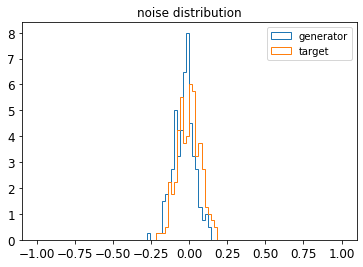

[0.300213248 1.39871323]
Epoch: 500 | disc_loss: 0.007414919324219227 | gen_loss: 0.09536182135343552
Epoch: 600 | disc_loss: -8.457794319838285e-05 | gen_loss: 0.07673326879739761
Epoch: 700 | disc_loss: 0.010909724049270153 | gen_loss: 0.05903036892414093
Epoch: 800 | disc_loss: -0.002131435554474592 | gen_loss: 0.13628341257572174
Epoch: 900 | disc_loss: 0.007789150811731815 | gen_loss: 0.05110497400164604


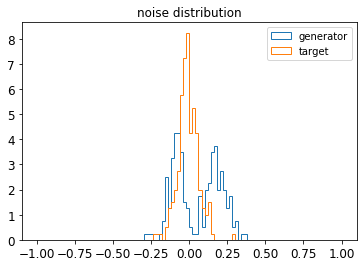

[-0.0916853547 0.0197316259]
Epoch: 1000 | disc_loss: 0.01211678609251976 | gen_loss: 0.05745065584778786
Epoch: 1100 | disc_loss: 0.010677146725356579 | gen_loss: 0.0750289335846901
Epoch: 1200 | disc_loss: -0.004143620375543833 | gen_loss: 0.09811428189277649
Epoch: 1300 | disc_loss: 0.0010791744571179152 | gen_loss: 0.09866312891244888
Epoch: 1400 | disc_loss: 0.007454353384673595 | gen_loss: 0.08466142416000366


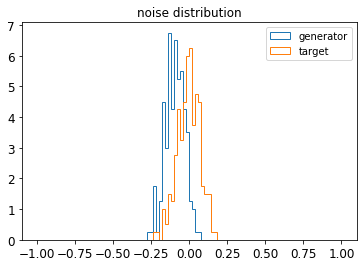

[0.631575763 -1.23267949]
Epoch: 1500 | disc_loss: 0.0031993831507861614 | gen_loss: 0.04165123030543327
Epoch: 1600 | disc_loss: 0.001169158611446619 | gen_loss: 0.028459856286644936
Epoch: 1700 | disc_loss: -0.004155473317950964 | gen_loss: 0.05873529613018036
Epoch: 1800 | disc_loss: 0.005613652523607016 | gen_loss: 0.11984805017709732
Epoch: 1900 | disc_loss: -0.00011175149120390415 | gen_loss: 0.15895171463489532


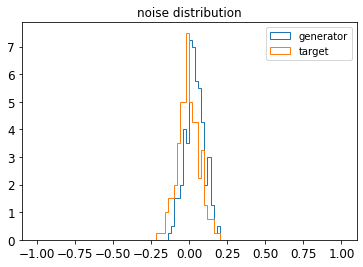

[0.62177676 -1.62126577]
Epoch: 2000 | disc_loss: 0.0003524142666719854 | gen_loss: 0.14517319202423096
INFO:tensorflow:Assets written to: /tmp/saved_model/assets
Time for the training is 1143.356437444687 sec,
CPU times: user 22min 22s, sys: 36 s, total: 22min 58s
Wall time: 19min 3s


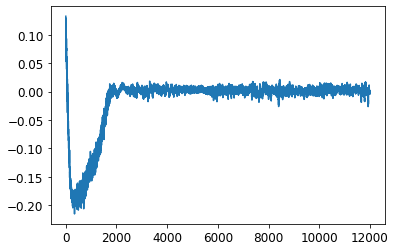

In [30]:
%%time
start = time.time()

for i in range(3):
  test_encoding(M,n)
  decoder_training(501, 100)
  gen_train(2001,100)
  decoder_training(2001, 100)
  #encoder_training(501,100)
  #test_encoding(M,n)
  encoder_training(1501,100)
  #test_encoding(M,n)
  gen_train(2001,100)


time_to_train_gan = time.time()-start
tf.print ('Time for the training is {} sec,'.format( time.time()-start))

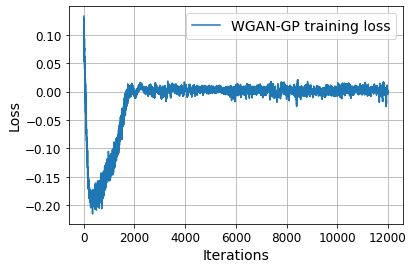

In [31]:
plt.plot(losses.disc_loss.values) 
plt.ylabel("Loss", fontsize=14, rotation=90)
plt.xlabel("Iterations", fontsize=14)
plt.legend(['WGAN-GP training loss'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")

Train on 10000000 samples
Epoch 1/10
  197000/10000000 [..............................] - ETA: 1:41 - loss: 4.5358e-06 - accuracy: 1.0000

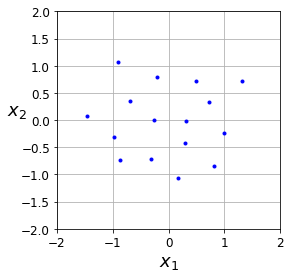

CPU times: user 29.7 s, sys: 1.01 s, total: 30.7 s
Wall time: 23.6 s


In [38]:
%%time
generator.trainable =False
encoder.trainable = True
decoder.trainable = True
gan_AE = tf.keras.models.Sequential([encoder,generator,decoder])
data = random_sample(10000000)
start = time.time()
gan_AE.compile(optimizer=keras.optimizers.Nadam(0.0005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = gan_AE.fit(data, data, batch_size=500,steps_per_epoch=400, epochs=10)

test_encoding(M,n)


# AE training

In [0]:
# test msg sequence for normal encoding
N_test = 500000
test_msg = np.random.randint(M, size=N_test)

### Comparison

In [40]:
gan_bber_data = gan_Test_AE(test_msg)

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


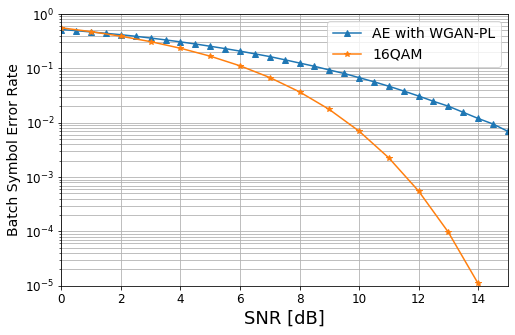

In [41]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(gan_bber_data[0], gan_bber_data[1], '^-')
plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '*-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['AE with WGAN-PL', '16QAM'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")
#print('time to train the AE Model with GAN',time_to_train_gan)


In [36]:
bber_data_rayleigh = Test_AE_rayleigh(test_msg)

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


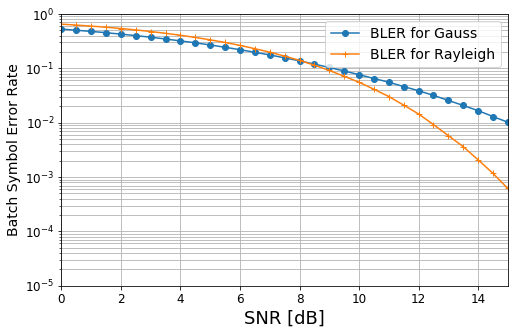

In [37]:
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(gan_bber_data[0], gan_bber_data[1], 'o-')
plt.semilogy(bber_data_rayleigh[0], bber_data_rayleigh[1], '+-')
#plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '^-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['BLER for Gauss','BLER for Rayleigh'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")
#plt.savefig('home/ben/Downloads/MineRayleigh.eps', format='eps')